In [2]:
'''
Make a dictionary of yoga businesses listed on Yelp,
including their names, URL's, addresses & phone numbers.
'''
import urllib2
from bs4 import BeautifulSoup
import re
from pprint import pprint
import pickle

yoga_biz_dict = {}
num_entry     = 0
base_url      = "http://www.yelp.com"
#page_url      = "/search?find_desc=Yoga&find_loc=New+York%2C+NY&ns=1#start=0&cflt=yoga"
page_url      = "/search?find_desc=yoga&find_loc=Los+Angeles%2C+CA&ns=1#start=0&cflt=yoga"

# Make a dictionary of basic info for all yoga studios listed on Yelp for the selected region:
more_pages = True
while more_pages:
    page     = urllib2.urlopen(base_url+page_url)
    soup     = BeautifulSoup(page)
    for obj1 in soup.find_all("span",class_="indexed-biz-name"):
        biz_url     = ''
        biz_name    = ''
        biz_rating  = 0
        biz_reviews = 0
        biz_hood    = ''
        biz_address = ''
        biz_phone   = ''
        if obj1:
            obj2 = obj1.find_next("a")
            if obj2:
                obj3 = obj2.get("href")
                if obj3:
                    biz_url  = "http://www.yelp.com"+obj3
                biz_name = unicode(obj2.string).encode('ascii', 'replace')

            obj2        = obj1.find_next("div",class_="rating-large")
            if obj2:
                biz_rating  = float(obj2.find_next("i")['title'].split()[0])

            obj2        = obj1.find_next("span",class_="review-count rating-qualifier")
            if obj2:
                biz_reviews = int(obj2.string.split()[0])

            obj2        = obj1.find_next("span",class_="neighborhood-str-list")
            if obj2:
                biz_hood    = obj2.string.strip()

            obj2        = obj1.find_next("span",class_="biz-phone")
            if obj2:
                biz_phone   = obj2.string.strip()

            obj2        = obj1.find_next("div",class_="secondary-attributes")
            if obj2:
                for item in obj2.children:
                    obj3 = unicode(item).encode('ascii', 'replace')
                    if "<address>" in obj3:
                        biz_address = obj3.replace('<address>','').replace('</address>','')\
                                      .replace('<br>',', ').replace('</br>','').strip()
            num_entry += 1
            yoga_biz_dict[num_entry] = [biz_name,biz_url,biz_rating,biz_reviews,
                                        biz_hood,biz_address,biz_phone]
            
    obj1 = soup.find("a",class_="page-option prev-next next")
    if obj1:
        page_url = obj1.get("href")
    else:
        more_pages = False

print 'Number of yoga businesses scraped = %i' % num_entry
            
with open('LA_yoga_businesses.pkl', 'w') as f:
    pickle.dump(yoga_biz_dict, f)

Number of yoga businesses scraped = 1000


In [3]:
'''
Have a quick look at how many "unique" yoga businesses we picked up,
in terms of their names and url's.
'''
from pprint import pprint
import pickle
with open('LA_yoga_businesses.pkl', 'r') as f:
    yoga_biz_dict = pickle.load(f)
print 'Number of dictionary entries = %i' % len(yoga_biz_dict)

yoga_biz       = set()
for key,value in yoga_biz_dict.items():
    yoga_biz.add(tuple(value))
print 'Number of yoga businesses =     %i' % len(yoga_biz)

yoga_biz_urls = set()
for key,value in yoga_biz_dict.items():
    yoga_biz_urls.add(value[1])
print 'Number of yoga business urls =  %i' % len(yoga_biz_urls)

yoga_biz_names = set()
for key,value in yoga_biz_dict.items():
    yoga_biz_names.add(value[0])
print 'Number of yoga business names = %i' % len(yoga_biz_names)

print yoga_biz_names

Number of dictionary entries = 1000
Number of yoga businesses =     863
Number of yoga business urls =  841
Number of yoga business names = 797
set(['The Alchemy Gardens', 'Wheel of Wellbeing', 'Chakra Integration Massage Therapy', 'The Star Temple of Bliss', 'Sadie?s Pole Gym', 'Hollywood Wilshire YMCA', 'Holistic Health Healing & Fitness with Leslie Porter', 'Echo Park Lake', 'Namaste Highland Park', 'Liberation Yoga', 'Jun Chong Tae Kwon Do', 'Fit Body Boot Camp', 'Yael?s Center of Healing', 'Elizabeth Perry Yoga', 'Liz Smith Pilates', 'Evolve Yoga Sacred Healing and Creative Arts', 'LiveYoga Wellness', 'Calico Yoga Studio', 'Brittany Wilkerson Yoga', 'Master Kim Yoga Institute', 'YogaWorks West Hollywood', 'Private Yoga Transforming yoga', 'Silver Lake Meadow', 'Earth Yoga', 'Thai House Massage', 'Brick Los Angeles', 'Two Hearts Yoga', 'Ganesha House', 'Yoga With Lois', 'Michelle Mikolis Yoga', 'Libby Pilates', 'Coast Fitness', 'Boxing District', 'Massage & Yoga', 'CHI - Create Hea

In [4]:
'''
Make a dictionary with yoga businesses that have a yelp url,
so we can fetch their reviews later.
'''
from pprint import pprint
import pickle

with open('LA_yoga_businesses.pkl', 'r') as f:
    yoga_biz_dict = pickle.load(f)
    
# Make a dictionary of yoga studios with unique url's
yoga_biz_url_dict = {}
for key1,value1 in yoga_biz_dict.items():
    url_len = len(yoga_biz_url_dict)
    already = False
    if url_len > 0:
        for key2,value2 in yoga_biz_url_dict.items():
            if value2[1] == value1[1]:
                already = True
                break
    if not already:
        yoga_biz_url_dict[key1] = value1

print 'Number of yoga businesses with unique urls = %i' % len(yoga_biz_url_dict)

with open('LA_yoga_businesses_unique_urls.pkl', 'w') as f:
    pickle.dump(yoga_biz_url_dict, f)

Number of yoga businesses with unique urls = 841


In [3]:
'''
Here we scrape the pages with Yelp reviews for each of the yoga
businesses we collected previously.  The result of the scraping
is stored in MongoDB collections yyrnyc and yyrla.

Don't forget to run mongod before starting this.
'''
import urllib2
from bs4 import BeautifulSoup
import re
from pprint import pprint
import pickle
from pymongo import MongoClient

client   = MongoClient()

# We set the yoga practice area (e.g. NYC or LA) here and in the pickle below.
yyr      = client.dsbc.yyrla
cursor   = yyr.find()
url_done = []
for record in cursor:
    url_done.append(record['biz_num'])
print 'Number or urls already in database = %i' % len(url_done)

# Here is the second and only other place where we set the yoga practice area:
with open('LA_yoga_businesses_unique_urls.pkl', 'r') as f:
    yoga_biz_url_dict = pickle.load(f)

nsave = 0
nurls = 0
for key,value in yoga_biz_url_dict.items():
    if key not in url_done:
        nurls += 1
        if nurls%10 == 1:
            print '%i: Now at yoga business %i: "%s"' % (nurls,key,value[0])
        review_num = 0
        nreviews   = value[3]
        review     = {}
        review['biz_num']     = key
        review['biz_name']    = value[0]
        review['biz_url']     = value[1]
        review['biz_rating']  = value[2]
        review['n_reviews']   = value[3]
        review['biz_hood']    = value[4]
        review['biz_address'] = value[5]
        review['biz_phone']   = value[6]
        review['biz_website'] = ""
        review['usr_id']      = []           
        review['usr_name']    = []
        review['usr_loc']     = []
        review['usr_friends'] = []
        review['usr_reviews'] = []
        review['usr_rating']  = []
        review['usr_pubdate'] = []
        review['usr_lang']    = []
        review['usr_text']    = []
        review['usr_useful']  = []
        review['usr_funny']   = []
        review['usr_cool']    = []

        base_url   = value[1]
        page_url   = base_url
        first_page = True
        more_pages = True
        while more_pages:
            page     = urllib2.urlopen(page_url)
            soup     = BeautifulSoup(page)
            
            if first_page:
                first_page = False
                obj1       = soup.find("div",class_="biz-website")
                if obj1:
                    review['biz_website'] = obj1.a.string

            for obj1 in soup.find_all("div",class_="review review--with-sidebar"):
                user_id     = ''
                author      = ''
                user_loc    = ''
                friend_cnt  = 0
                review_cnt  = 0
                rating      = ''
                pub_date    = ''
                language    = ''
                description = ''
                useful      = 0
                funny       = 0
                cool        = 0
                if obj1:
                    user_id = obj1["data-signup-object"].replace("user_id:","")

                    obj2 = obj1.find_next("meta",itemprop="author")
                    if obj2:
                        author = obj2["content"]

                    obj2 = obj1.find_next("li",class_="user-location")
                    if obj2:
                        user_loc = obj2.b.string

                    obj2 = obj1.find_next("li", class_="friend-count")
                    if obj2:
                        friend_cnt = int(obj2.span.b.string)

                    obj2 = obj1.find_next("li", class_="review-count")
                    if obj2:
                        review_cnt = int(obj2.span.b.string)

                    obj2 = obj1.find_next("meta",itemprop="ratingValue")
                    if obj2:
                        rating = obj2["content"]

                    obj2 = obj1.find_next("meta",itemprop="datePublished")
                    if obj2:
                        pub_date = obj2["content"]

                    obj2 = obj1.find_next("p",itemprop="description")
                    if obj2:
                        language = obj2["lang"]
                        for string in obj2.strings:
                            description = description + string

                    obj2 = obj1.find_next("a",class_="ybtn ybtn-small useful")
                    if obj2:
                        obj3 = obj2.find_next("span",class_="count")
                        if obj3:
                            if obj3.string:
                                useful = int(obj3.string)

                    obj2 = obj1.find_next("a",class_="ybtn ybtn-small funny")
                    if obj2:
                        obj3 = obj2.find_next("span",class_="count")
                        if obj3:
                            if obj3.string:
                                funny = int(obj3.string)

                    obj2 = obj1.find_next("a",class_="ybtn ybtn-small cool")
                    if obj2:
                        obj3 = obj2.find_next("span",class_="count")
                        if obj3:
                            if obj3.string:
                                cool = int(obj3.string)

                    # Avoid saving duplicate reviews:
                    if description not in review['usr_text']:
                        review_num += 1
                        review['usr_id'].append(user_id)            
                        review['usr_name'].append(author)
                        review['usr_loc'].append(user_loc)
                        review['usr_friends'].append(friend_cnt)
                        review['usr_reviews'].append(review_cnt)
                        review['usr_rating'].append(rating)
                        review['usr_pubdate'].append(pub_date)
                        review['usr_lang'].append(language)
                        review['usr_text'].append(description)
                        review['usr_useful'].append(useful)
                        review['usr_funny'].append(funny)
                        review['usr_cool'].append(cool)
                    
            obj1 = soup.find("a",class_="page-option prev-next next")
            if obj1:
                page_url = obj1.get("href")
            else:
                more_pages = False
                
        if review_num != nreviews:
            print 'At yoga business %i, "%s": reviews expected = %i, found = %i' \
                    % (key,value[0],nreviews,review_num)
            review['n_reviews'] = review_num

        if review_num > 0:
            yyr.save(review)
            nsave += 1
            
print 'Number of records added to the database: %i' % nsave

Number or urls already in database = 233
1: Now at yoga business 180: "Salt & Yoga"
At yoga business 218, "The Energy Gurus": reviews expected = 54, found = 0
At yoga business 222, "Factory Place Yoga": reviews expected = 13, found = 0
At yoga business 227, "Param Yoga": reviews expected = 292, found = 0
At yoga business 237, "Krystal Spa": reviews expected = 1, found = 0
At yoga business 268, "YogaGals": reviews expected = 12, found = 0
11: Now at yoga business 282: "Govilove Ayurveda"
At yoga business 283, "Calico Yoga Studio": reviews expected = 32, found = 0
At yoga business 286, "Divine Wellness Yoga": reviews expected = 6, found = 0
At yoga business 288, "Mary Shore Yoga Center": reviews expected = 12, found = 0
At yoga business 291, "Yoga World": reviews expected = 31, found = 0
21: Now at yoga business 292: "lululemon athletica"
At yoga business 294, "YogaWorks South Bay": reviews expected = 149, found = 148
At yoga business 297, "Hera": reviews expected = 44, found = 0
31: Now

In [2]:
'''
This is to delete from a yyr Mongo collection any yoga studio entries that
have no reviews.
'''
from pymongo import MongoClient

client   = MongoClient()

# We set the yoga practice area (e.g. yyrnyc for NYC, and yyrla for LA) here.
yyr      = client.dsbc.yyrla
print 'Number of database entries = %i' % yyr.count()
cursor   = yyr.find()
remover  = []
n_empty  = 0
for record in cursor:
    n_reviews = len(record['usr_text'])
    if n_reviews == 0:
        n_empty += 1
        key      = record["_id"]
        remover.append(key)
print 'Number of studios without review = %i' % n_empty

for key in remover:
    yyr.remove({"_id":key})
print 'Number of database entries = %i' % yyr.count()

Number of database entries = 537
Number of studios without review = 304
Number of database entries = 233


Number of yoga businesses in database = 796
Business "Yoga Agora [at] 33-02 Broadway, Astoria, NY 11106" has 165 reviews
Business "Yoga Vida [at] 99 University Pl, New York, NY 10003" has 130 reviews
Business "Yoga to the People [at] 12 St. Marks Pl, New York, NY 10003" has 331 reviews
Business "Bikram Yoga Lower East Side [at] 172 Allen St, New York, NY 10002" has 134 reviews
Business "Jivamukti Yoga School [at] 841 Broadway, New York, NY 10003" has 128 reviews
Business "Exhale Central Park South [at] 150 Central Park S, New York, NY 10019" has 146 reviews

Number of businesses with 0 reviews = 246
Number of businesses with at least 1,2,3,10,100 reviews = 550, 461, 396, 221, 10
Number of discrepancies = 0
Total number of reviews in database = 9299


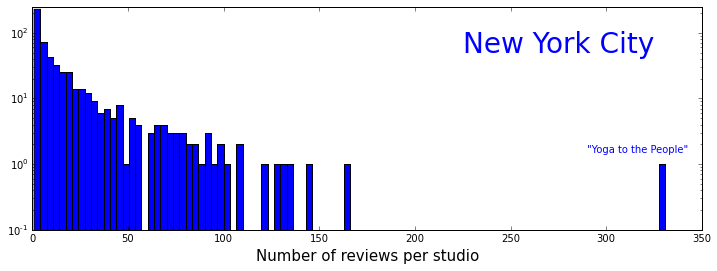

In [1]:
'''
Let's look at what we have in MongoDB, collection yyrnyc in database dsbc.
'''
%matplotlib inline
from pymongo import MongoClient
import matplotlib.pyplot as plt

client   = MongoClient()
yyr      = client.dsbc.yyrnyc  # New York City area
print 'Number of yoga businesses in database = %i' % yyr.count()
cursor   = yyr.find()

n0       = 0
n1       = 0
n2       = 0
n3       = 0
n10      = 0
n100     = 0
ndis     = 0
nrlistnyc= []
rtotal   = 0
rlengths = []
for record in cursor:
    for review in record['usr_text']:
        rlengths.append(len(review))
    nreviews = len(record['usr_text'])
    rtotal  += nreviews
    if nreviews != 0: nrlistnyc.append(nreviews)
    if nreviews > 99: 
        n100 += 1
    if nreviews > 120:
        print 'Business "%s [at] %s" has %i reviews' \
        % (record['biz_name'],record['biz_address'],nreviews)
    if nreviews > 9:   n10 += 1
    if nreviews > 2:    n3 += 1
    if nreviews > 1:    n2 += 1
    if nreviews > 0:    n1 += 1
    if nreviews == 0:   n0 += 1
    if nreviews != record['n_reviews']: 
        ndis += 1
        print 'For business "%s" we expected %i reviews, found %i' \
        %(record['biz_name'],record['n_reviews'],nreviews)

print
print 'Number of businesses with 0 reviews = %i' % n0
print 'Number of businesses with at least 1,2,3,10,100 reviews = %i, %i, %i, %i, %i' \
% (n1,n2,n3,n10,n100)
print 'Number of discrepancies = %i' % ndis
print 'Total number of reviews in database = %i' % rtotal

# Histogram the number of reviews per studio, for studios with at least one review:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(12,4) )
ax.hist( nrlistnyc, color='b', bins=100 )
ax.set_xlabel('Number of reviews per studio', fontsize=15)
ax.set_ylim(0.1,250.0)
ax.set_yscale('log')
ax.text(225.0,50.0,"New York City",size=28,color='b')
ax.text(290.0,1.5,'"Yoga to the People"',size=10,color='b')
plt.show()
#fig.savefig("n_reviews_nyc.pdf")

Number of yoga businesses in database = 749
Business "Modo Yoga LA [at] 340 S La Brea Ave, Los Angeles, CA 90036" has 185 reviews
Business "Liberation Yoga [at] 124 S La Brea Ave, Los Angeles, CA 90036" has 135 reviews
Business "YogaWorks [at] 230 1/2 N Larchmont Blvd, Los Angeles, CA 90004" has 138 reviews
Business "Earth?s Power Yoga Center [at] 7901 Melrose Ave, Los Angeles, CA 90046" has 127 reviews
Business "The Raven Spa [at] 2910 Rowena Ave, Los Angeles, CA 90039" has 230 reviews
Business "Bikram Yoga Downtown LA [at] 700 W 1st St, Los Angeles, CA 90012" has 180 reviews
Business "The Springs [at] 608 Mateo St, Los Angeles, CA 90021" has 150 reviews
Business "CorePower Yoga [at] 11819 Wilshire Blvd., Los Angeles, CA 90025" has 135 reviews
Business "Bikram Yoga Silverlake [at] 3223 Glendale Blvd, Los Angeles, CA 90039" has 251 reviews
Business "Pop Physique [at] 3501 W Sunset Blvd, Los Angeles, CA 90026" has 175 reviews
Business "YAS Silverlake [at] 1932 Hyperion Ave, Los Angeles,

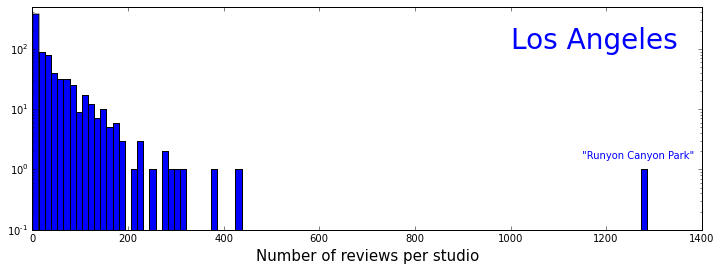

In [2]:
'''
Let's look at what we have in MongoDB, collection yyrla in database dsbc.
'''
%matplotlib inline
from pymongo import MongoClient
import matplotlib.pyplot as plt

client   = MongoClient()
yyr      = client.dsbc.yyrla  # Los Angeles area
print 'Number of yoga businesses in database = %i' % yyr.count()
cursor   = yyr.find()

n0       = 0
n1       = 0
n2       = 0
n3       = 0
n10      = 0
n100     = 0
ndis     = 0
nrlistla = []
rtotal   = 0
rlengths = []
for record in cursor:
    for review in record['usr_text']:
        rlengths.append(len(review))
    nreviews = len(record['usr_text'])
    rtotal  += nreviews
    if nreviews != 0: nrlistla.append(nreviews)
    if nreviews > 99: 
        n100 += 1
    if nreviews > 120:
        print 'Business "%s [at] %s" has %i reviews' \
        % (record['biz_name'],record['biz_address'],nreviews)
    if nreviews > 9:   n10 += 1
    if nreviews > 2:    n3 += 1
    if nreviews > 1:    n2 += 1
    if nreviews > 0:    n1 += 1
    if nreviews == 0:   n0 += 1
    if nreviews != record['n_reviews']: 
        ndis += 1
        print 'For business "%s" we expected %i reviews, found %i' \
        %(record['biz_name'],record['n_reviews'],nreviews)

print
print 'Number of businesses with 0 reviews = %i' % n0
print 'Number of businesses with at least 1,2,3,10,100 reviews = %i, %i, %i, %i, %i' \
% (n1,n2,n3,n10,n100)
print 'Number of discrepancies = %i' % ndis
print 'Total number of reviews in database = %i' % rtotal

# Histogram number of reviews per studio, for studios with at least one review:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(12,4) )
ax.hist( nrlistla, color='b', bins=100 )
ax.set_xlabel('Number of reviews per studio', fontsize=15)
ax.set_ylim(0.1,500.0)
ax.set_yscale('log')
ax.text(1000.0,100.0,"Los Angeles",size=28,color='b')
ax.text(1150.0,1.5,'"Runyon Canyon Park"',size=10,color='b')
plt.show()
# fig.savefig("n_reviews_la.pdf")

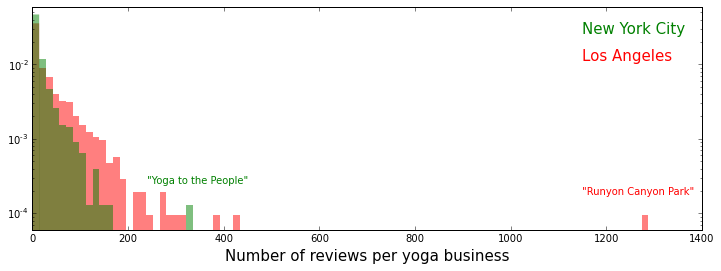

In [5]:
'''
Using nrlistnyc and nrlistla obtained in the previous two cells, make a histogram
of the number of reviews per studio, for studios with at least one review,
superimposing the NYC and LA results with different colors.
'''
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(12,4) )
ax.hist( nrlistla,  color='r', edgecolor='none', bins=100, range=[0.0,1400.0], \
         normed=True, alpha=0.5)
ax.hist( nrlistnyc, color='g', edgecolor='none', bins=100, range=[0.0,1400.0], \
         normed=True, alpha=0.5 )
ax.set_xlabel('Number of reviews per yoga business', fontsize=15)
ax.set_ylim(0.00006,0.06)
ax.set_yscale('log')
ax.text( 1150.0, 0.030, "New York City", ha='left', va='center', size=15, color='g')
ax.text( 1150.0, 0.013, "Los Angeles", ha='left', va='center', size=15, color='r')
ax.text( 1150.0, 0.00018, '"Runyon Canyon Park"', size=10, color='r')
ax.text(  240.0, 0.00025, '"Yoga to the People"', size=10, color='g')
plt.show()
fig.savefig("n_reviews_nyc_la.pdf")

In [13]:
'''
Let's see what we have in collections yyr and yyrnyc and
synchronize if necessary.  Both should contain yoga studio
reviews for the NYC area.
'''
from pymongo import MongoClient

client   = MongoClient()

yyr      = client.dsbc.yyr
cursor1  = yyr.find()

yyrnyc   = client.dsbc.yyrnyc
cursor2  = yyrnyc.find()

update2   = {}
n_1gt2    = 0
for record1 in cursor1:
    cursor2.rewind()
    for record2 in cursor2:
        if (record1["biz_name"] == record2["biz_name"]) and \
           (record1["biz_address"] == record2["biz_address"]):
            if len(set(record1["usr_text"])) > len(set(record2["usr_text"])):
                print '%i,%i, %s at %s' % (len(set(record1["usr_text"])),
                                           len(set(record2["usr_text"])),
                                           record1["biz_name"],
                                           record1["biz_address"])
                n_1gt2 += 1
                key     = record2["_id"]
                text    = record1["usr_text"]
                update2[key] = text
            break

for key,text in update2.items():
    nreviews = len(text)
    yyrnyc.update({"_id":key},{"$set":{"usr_text":text}})
    yyrnyc.update({"_id":key},{"$set":{"n_reviews":nreviews}})

print
print 'Studios in yyr with more reviews than in yyrnyc: %i' % n_1gt2

74,73, Bend & Bloom Yoga at 708 Sackett St, Brooklyn, NY 11217
99,98, Yoga to the People at 211 N 11th St, Brooklyn, NY 11211
9,8, Lila Yoga, Dharma & Wellness at 302 Bowery, New York, NY 10012
77,76, Pure Yoga at 203 E 86th St, New York, NY 10028
44,43, HotYoga4You Rego Park at 65-07 Woodhaven Blvd, Rego Park, NY 11374
44,43, Flex Hot Yoga at 221-50 Horace Harding Expy, Bayside, NY 11364
79,78, Crunch at 1109 2nd Ave, New York, NY 10022
30,29, Club Metro USA at 1642 Schlosser St, Fort Lee, NJ 07024
21,0, Hamilton Health & Fitness at 161 Erie St, Jersey City, NJ 07302
6,0, Verona Yoga and Wellness Center at 546 Bloomfield Ave, Verona, NJ 07044
1,0, Freestyle Fighting Fitness at 93-02 Linden Blvd, Ozone Park, NY 11417
1,0, Surfset Fitness At Spine and Soul at 213-33 40th St, Bayside, NY 11361
8,0, Conquering Lion Yoga at 815 Broadway, New York, NY 10003
9,0, Brooklyn Yoga Project at 185 Sackett St, Carroll Gardens, NY 11231
9,0, Bonda Yoga East at 4A Bond St, Great Neck, NY 11021
10,0, 